In [23]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np


train_data = pd.read_csv('train.csv')
train_X = train_data.iloc[0:2059, 3:8]
train_y = train_data.iloc[0:2059, 8]


test_data = pd.read_csv('test.csv')
test_X = test_data.iloc[0:2059, 3:8]


In [24]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler

#convert string to integer
def convert_to_number(value):
    if isinstance(value, float):
        return value
    elif value == '0':
        return 0.0
    elif 'Crore' in value:
        return float(value.replace(' Crore+', '')) * 10**7
    elif 'Lac' in value:
        return float(value.replace(' Lac+', '')) * 10**5
    elif 'Thou' in value:
        return float(value.replace(' Thou+', '')) * 10**3

#preprocess train data
train_data = pd.read_csv('train.csv')
train_X = train_data.iloc[0:2059, 3:8]
train_X['Total Assets'] = train_X['Total Assets'].apply(convert_to_number)
train_X['Liabilities'] = train_X['Liabilities'].apply(convert_to_number)
train_X['Liabilities'].fillna(0, inplace=True)
train_X = pd.get_dummies(train_X, columns=['state', 'Party'], drop_first=True)

#preprocess test data
test_data = pd.read_csv('test.csv')
test_X = test_data.iloc[0:2059, 3:8]
test_X['Total Assets'] = test_X['Total Assets'].apply(convert_to_number)
test_X['Liabilities'] = test_X['Liabilities'].apply(convert_to_number)
test_X['Liabilities'].fillna(0, inplace=True)
test_X = pd.get_dummies(test_X, columns=['state', 'Party'], drop_first=True)

# handle outliers
def boxcox_transform(data):
    transformed_data, _ = boxcox(data + 1)
    return transformed_data

train_X['Total Assets'] = boxcox_transform(train_X['Total Assets'])
train_X['Liabilities'] = boxcox_transform(train_X['Liabilities'])
test_X['Total Assets'] = boxcox_transform(test_X['Total Assets'])
test_X['Liabilities'] = boxcox_transform(test_X['Liabilities'])

# Apply StandardScaler to standardize features
scaler = StandardScaler()
train_X[['Total Assets', 'Liabilities']] = scaler.fit_transform(train_X[['Total Assets', 'Liabilities']])
test_X[['Total Assets', 'Liabilities']] = scaler.transform(test_X[['Total Assets', 'Liabilities']])

train_X


,Criminal Case,Total Assets,Liabilities,state_ARUNACHAL PRADESH,state_ASSAM,state_BIHAR,state_CHHATTISGARH,state_DELHI,state_GOA,state_GUJARAT,...,Party_NCP,Party_NDPP,Party_NPP,Party_RJD,Party_SHS,Party_SP,Party_Sikkim Krantikari Morcha,Party_TDP,Party_Tipra Motha Party,Party_YSRCP
0,4,2.871486,0.939314,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,-0.342322,-1.547292,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,0.484077,0.283465,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,0.613924,0.306257,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2,-0.081074,0.565658,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,1,-0.509367,0.087120,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2055,0,-0.081074,0.034743,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2056,0,0.815021,0.664919,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2057,1,1.207874,0.695794,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [25]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from scipy.stats import uniform, randint

# Define the parameter distributions for hyperparameter tuning
params = {
    'alpha': uniform(0.01, 5.0 - 0.01),  # Continuous uniform distribution between 0.01 and 5.0
    'binarize': uniform(0.0, 1.0),        # Continuous uniform distribution between 0.0 and 1.0
    'fit_prior': [True, False],           # Boolean values for fitting prior
    'class_prior': [None, [0.3, 0.7]]     # None or specific class priors
}

# Initialize the Bernoulli Naive Bayes classifier
bernoulli = BernoulliNB()

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(bernoulli, params, n_iter=50, cv=10, scoring='f1_weighted', random_state=42)
random_search.fit(train_X, train_y)
print("Optimal Parameters:",random_search.best_params_)
# Get the best estimator with optimal hyperparameters
best_bernoulli = random_search.best_estimator_

# Predict on the training set using the best estimator
y_pred_train = best_bernoulli.predict(train_X)

# Calculate the F1 score on the training set
f1_train = f1_score(train_y, y_pred_train, average='weighted')
print("F1 Score on Training Set:", f1_train)

# Predict on the test set using the best estimator
y_pred_test = best_bernoulli.predict(test_X)

y_pred_test


Optimal Parameters: {'alpha': 0.6081281829950772, 'binarize': 0.33761517140362796, 'class_prior': None, 'fit_prior': True}
F1 Score on Training Set: 0.26183976960877253


array(['10th Pass', '12th Pass', 'Graduate', ..., 'Graduate',
       'Post Graduate', 'Post Graduate'], dtype='<U21')

In [26]:
result = pd.DataFrame({'ID': range(len(y_pred_test)), 'Education': y_pred_test})
result.to_csv('submission.csv', index=False)

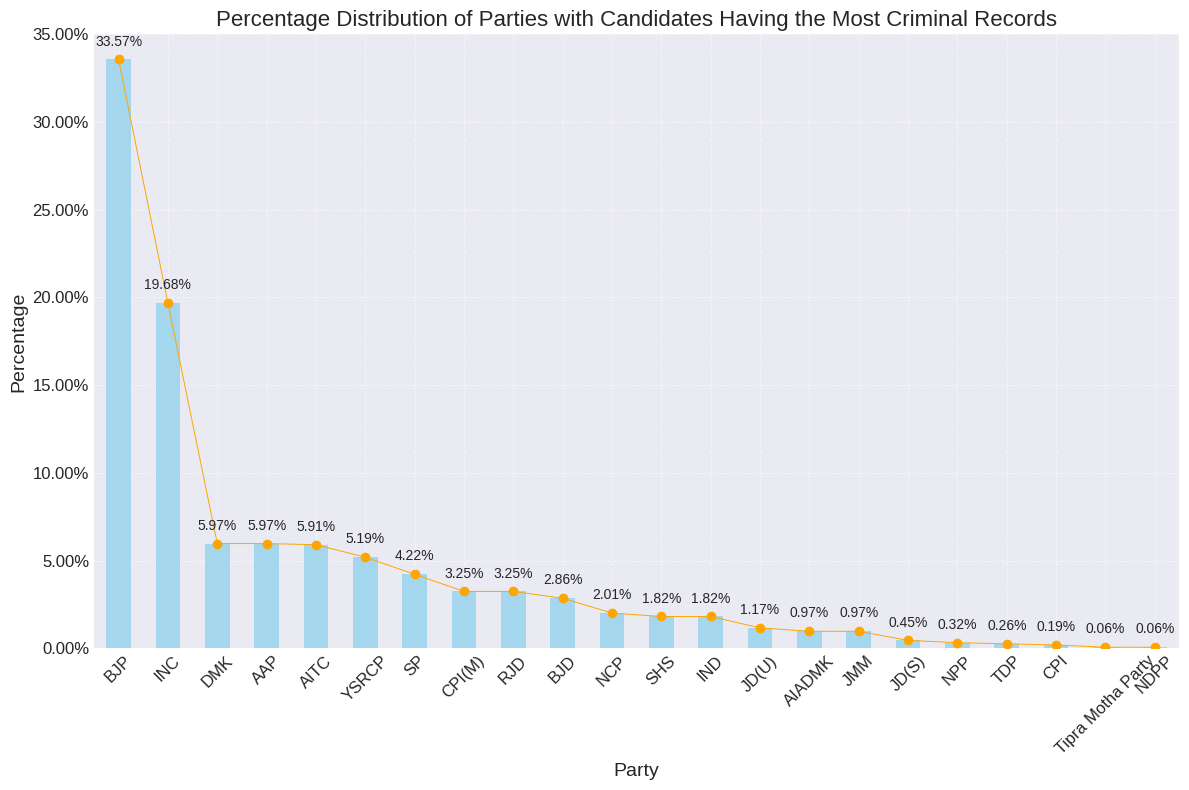

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
data = pd.concat([train_data, test_data], ignore_index=True)


total_criminal_candidates = (data['Criminal Case'] > 0).sum()


party_criminal_counts = data[data['Criminal Case'] > 0]['Party'].value_counts()


percentage_distribution = (party_criminal_counts / total_criminal_candidates) * 100


numeric_index = range(len(percentage_distribution))

# Plotting
plt.figure(figsize=(12, 8))
percentage_distribution.plot(kind='bar', color='skyblue', alpha=0.7)
line_plot = plt.plot(numeric_index, percentage_distribution.values, marker='o', color='orange', linewidth=0.7)

# Title and labels
plt.title('Percentage Distribution of Parties with Candidates Having the Most Criminal Records', fontsize=16)
plt.xlabel('Party', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(numeric_index, percentage_distribution.index, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.gca().set_yticklabels(['{:.2f}%'.format(x) for x in plt.gca().get_yticks()])
plt.ylim(0, 35)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
sns.despine()

# Annotate values
for i, value in enumerate(percentage_distribution.values):
    plt.annotate('{:.2f}%'.format(value), (numeric_index[i], value),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)

plt.show()


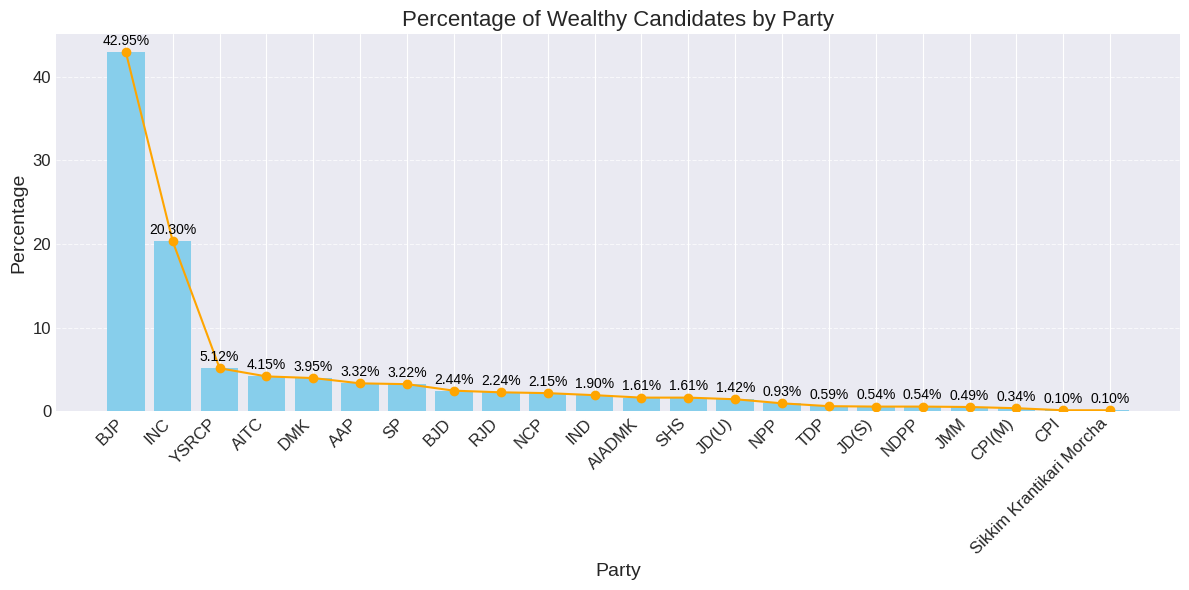

In [28]:
def convert_to_number(value):
    if isinstance(value, float):
        return value
    elif value == '0':
        return 0.0
    elif 'Crore' in value:
        return float(value.replace(' Crore+', '')) * 10**7
    elif 'Lac' in value:
        return float(value.replace(' Lac+', '')) * 10**5
    elif 'Thou' in value:
        return float(value.replace(' Thou+', '')) * 10**3


data['Total Assets'] = data['Total Assets'].apply(convert_to_number)
data['Liabilities'] = data['Liabilities'].apply(convert_to_number)
data['Liabilities'].fillna(0, inplace=True)

threshold = 10000000

def calculate_net_worth(row):
    assets = row['Total Assets']
    liabilities = row['Liabilities']
    return assets - liabilities

data['Net Worth'] = data.apply(calculate_net_worth, axis=1)

wealthy_candidates = data[data['Net Worth'] > threshold]

wealthy_party_counts = wealthy_candidates['Party'].value_counts()

percentage_distribution = (wealthy_party_counts / len(wealthy_candidates)) * 100

plt.style.use('seaborn-darkgrid')



# Plot the bar chart
plt.figure(figsize=(12, 6))  # Increase figure width
bars = plt.bar(percentage_distribution.index, percentage_distribution.values, color='skyblue', width=0.8)  # Adjust the width
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and adjust font size

# Connect bars by a line
plt.plot(percentage_distribution.index, percentage_distribution.values, marker='o', color='orange', linestyle='-')

# Display the value for each party on top of its bar with some padding
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}%', va='bottom', ha='center', color='black', fontsize=10)

# Title and labels
plt.title('Percentage of Wealthy Candidates by Party', fontsize=16)
plt.xlabel('Party', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

# Tick labels
plt.yticks(fontsize=12)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

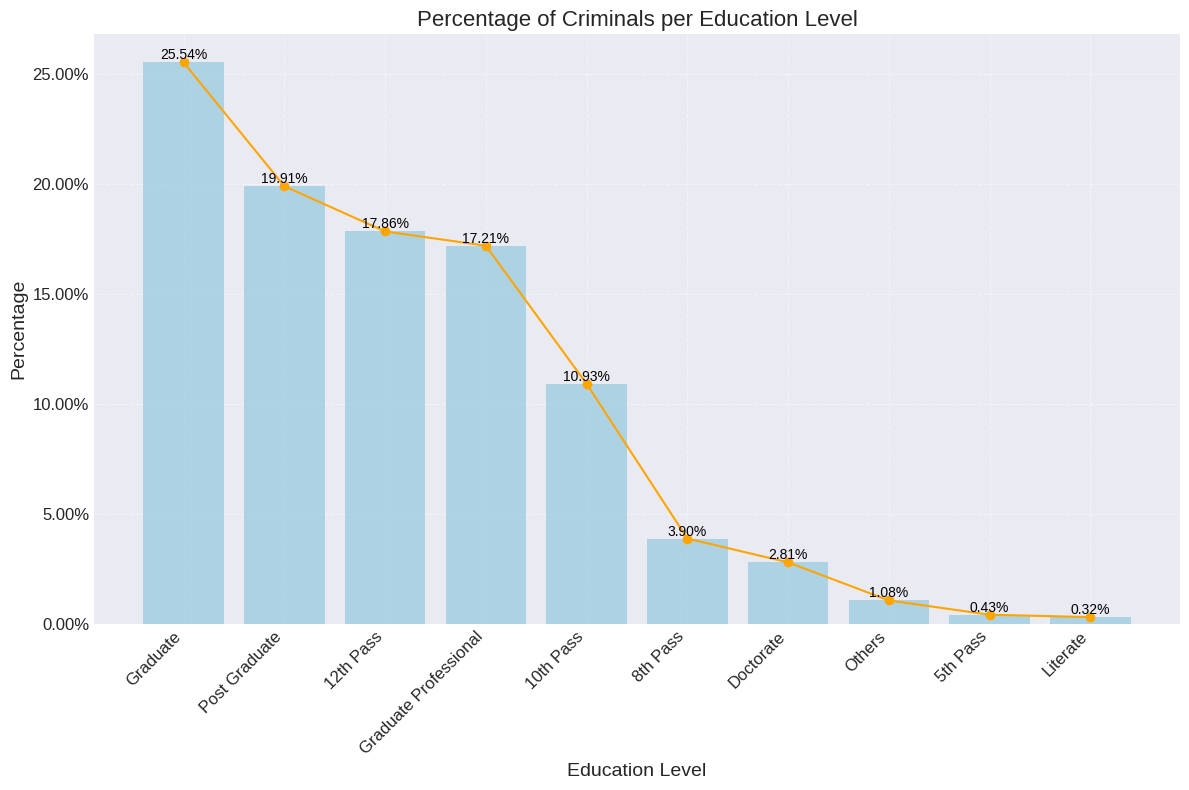

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
train_data = pd.read_csv('train.csv')

# Calculate the total number of candidates with criminal cases
total_criminals = train_data[train_data['Criminal Case'] > 0]['ID'].count()

# Calculate the percentage of criminals per education level
criminals_per_education = (train_data[train_data['Criminal Case'] > 0]['Education'].value_counts() / total_criminals) * 100

# Plotting
plt.figure(figsize=(12, 8))
bars = sns.barplot(x=criminals_per_education.index, y=criminals_per_education.values, color='skyblue', alpha=0.7)

# Connect centers of tops of bars by a line
centers_x = [bar.get_x() + bar.get_width() / 2 for bar in bars.patches]
centers_y = [bar.get_height() for bar in bars.patches]

plt.plot(centers_x, centers_y, marker='o', color='orange', linestyle='-')

# Write value of bars on top
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}%', va='bottom', ha='center', color='black', fontsize=10)

# Title and labels
plt.title('Percentage of Criminals per Education Level', fontsize=16)
plt.xlabel('Education Level', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.gca().set_yticklabels(['{:.2f}%'.format(x) for x in plt.gca().get_yticks()])
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


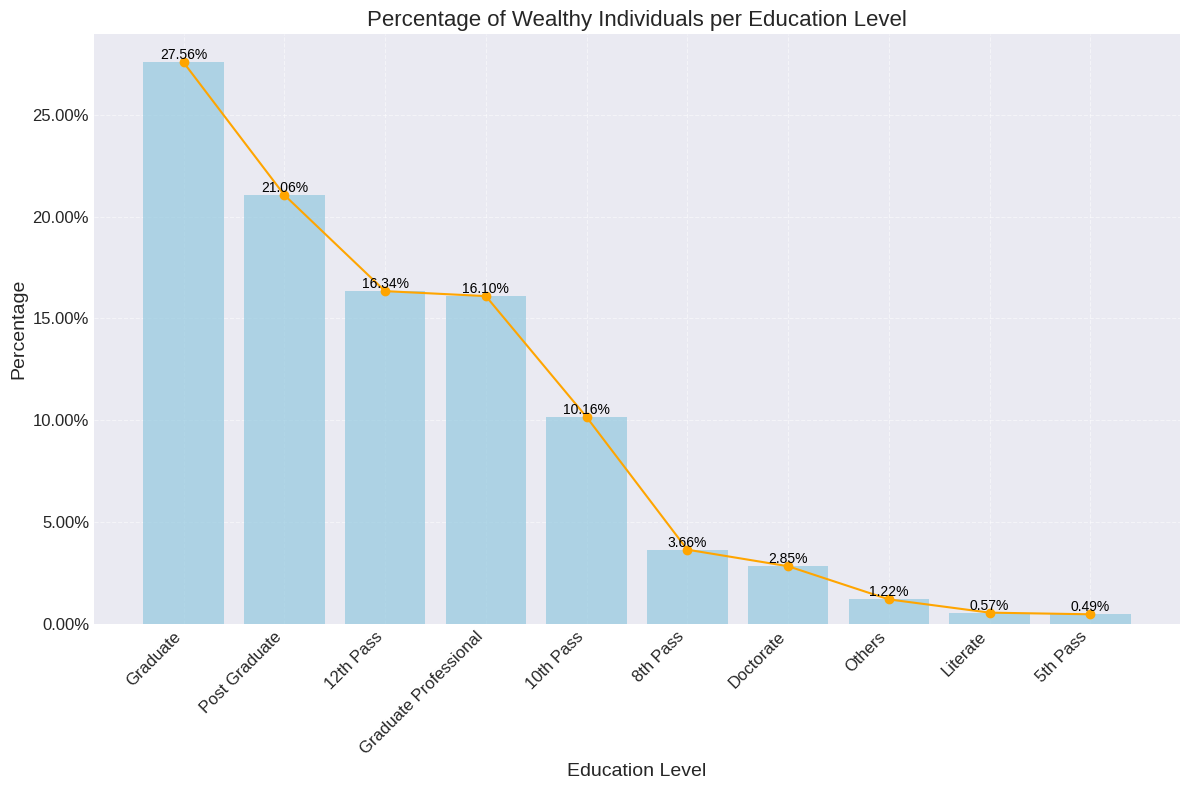

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
train_data = pd.read_csv('train.csv')

# Define function to convert assets and liabilities to numeric values
def convert_to_numeric(value):
    if isinstance(value, float):
        return value
    elif value == '0':
        return 0.0
    elif 'Crore' in value:
        return float(value.replace(' Crore+', '')) * 10**7
    elif 'Lac' in value:
        return float(value.replace(' Lac+', '')) * 10**5
    elif 'Thou' in value:
        return float(value.replace(' Thou+', '')) * 10**3

# Convert assets and liabilities to numeric
train_data['Total Assets'] = train_data['Total Assets'].apply(convert_to_numeric)
train_data['Liabilities'] = train_data['Liabilities'].apply(convert_to_numeric)
train_data['Liabilities'].fillna(0, inplace=True)

# Calculate wealth
train_data['Wealth'] = train_data['Total Assets'] - train_data['Liabilities']

# Create a binary column indicating whether a person is wealthy or not
train_data['Wealthy'] = train_data['Wealth'] > 10000000

# Calculate the total number of wealthy individuals
total_wealthy = train_data[train_data['Wealthy']]['ID'].count()

# Calculate the percentage of wealthy individuals per education level
wealthy_per_education = (train_data[train_data['Wealthy']].groupby('Education')['ID'].count() / total_wealthy) * 100
wealthy_per_education = wealthy_per_education.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
bars = sns.barplot(x=wealthy_per_education.index, y=wealthy_per_education.values, color='skyblue', alpha=0.7, order=wealthy_per_education.index)

# Connect centers of tops of bars by a line
centers_x = [bar.get_x() + bar.get_width() / 2 for bar in bars.patches]
centers_y = [bar.get_height() for bar in bars.patches]

plt.plot(centers_x, centers_y, marker='o', color='orange', linestyle='-')

# Write value of bars on top
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}%', va='bottom', ha='center', color='black', fontsize=10)

# Title and labels
plt.title('Percentage of Wealthy Individuals per Education Level', fontsize=16)
plt.xlabel('Education Level', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.gca().set_yticklabels(['{:.2f}%'.format(x) for x in plt.gca().get_yticks()])
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()
